In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder

import torch.nn as nn
import torch.nn.functional as F

## 前置作業
- 要先建立好資料夾train/data/bad,good,none以及test/data/good,bad,none

In [41]:
def processImage(nameStr):
    
    if nameStr == 'train':
        data = np.loadtxt('train.csv',dtype=np.str,delimiter=',')[1:]
        # 更改有錯的檔案名稱
        idx = np.where(data[:,0]=='AR-200139872.jpg_NCS_modified=&exif=.jpg')
        data[idx,0] = 'AR-200139872.jpg_NCS_modified=_exif=.jpg'
        # 因為檔名過大而無法存取 因此改檔名
        idx = np.where(data[:,0]=='chinese-wear-face-masks-to-protect-against-the-heavy-smog-hanging-over-beijing-on-november-17-2016-chinas-capital-warned-its-20-million-residents-to-limit-outdoor-activities-to-avoid-the-ill-effects-of-heavy-pollution-blanketing-the-city-ph.jpg')
    
    elif nameStr == 'test':
        data = np.loadtxt('test.csv',dtype=np.str,delimiter=',')[1:]
        
    dataAmt = len(data)

    for i in range(dataAmt):
        left = int(data[:,-4][i]) # xmin
        bottom = int(data[:,-3][i]) # ymin
        right = int(data[:,-2][i]) # xmax
        top = int(data[:,-1][i]) # ymax

        label = data[:,3][i]

        img = Image.open('../images/' + data[:,0][i])
        img_crop = img.crop((left, bottom, right, top)) 
        img_crop = img_crop.convert("RGB")
        img_crop.save(nameStr+'/data/'+label+'/'+str(i)+'.jpg',"JPEG")

In [42]:
processImage("train")
processImage("test")

In [43]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # 將圖片轉成tensor
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]) # normalization
])

In [44]:
trainSet = ImageFolder('train/data/',transform=transform)
print("train length:",len(trainSet),", class index:", trainSet.class_to_idx)
testSet = ImageFolder('test/data/',transform=transform)
print("test length:",len(testSet),", class index:", testSet.class_to_idx)

train length: 3528 , class index: {'bad': 0, 'good': 1, 'none': 2}
test length: 394 , class index: {'bad': 0, 'good': 1, 'none': 2}


In [45]:
numClass = len(trainSet.class_to_idx)
numClass # 類別種數

3

In [46]:
trainloader = torch.utils.data.DataLoader(trainSet, 
                                          batch_size=1, 
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testSet, 
                                         batch_size=1,
                                         shuffle=False)

## 網路架構

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.ada = nn.AdaptiveAvgPool2d((32,32))
        self.conv1 = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.fc1 = nn.Linear(10 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, numClass)

    def forward(self, x):
        x = self.ada(x)
        x = self.pool(F.relu(self.conv1(x))) # 15 * 15
        x = self.pool(F.relu(self.conv2(x))) #  6 * 6
        x = x.view(-1, 10 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.ada = nn.AdaptiveAvgPool2d((32,32))
#         self.conv1 = nn.Conv2d(3, 6, 5,stride=2)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5,stride=2)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 3) #84,3

#     def forward(self, x):
#         x = self.ada(x)
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# net = Net()

In [25]:
# loss 
criterion = nn.CrossEntropyLoss()

# optimizer & set learning rate
learning_rate = 0.001
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

epochs = 10
epoch_loss = []
epoch_train_acc = []
epoch_test_acc = []

print('Epochs: ', epochs, ', learning rate: ', learning_rate)
net

Epochs:  10 , learning rate:  0.001


Net(
  (ada): AdaptiveAvgPool2d(output_size=(32, 32))
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=360, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [26]:
for epoch in range(epochs):
    
    losses = 0.0
    train_acc = 0 
    test_acc = 0
    
    # 各類別分對了的數量累計
    trainAccEachClass = [0]*numClass
    testAccEachClass = [0]*numClass
    
    # 各類別數量(從原始data之label統計)
    trainClassCount = [0]*numClass
    testClassCount = [0]*numClass
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        
        # training accuracy
        pred = np.argmax(outputs.detach().numpy())
        
        # new
        trainClassCount[labels] += 1
        
        if pred == labels:
            train_acc += 1
            trainAccEachClass[labels] += 1
        
        # loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses += loss.item()
        
    # testing
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        
        # testing accuracy
        pred = np.argmax(outputs.detach().numpy())
        
        testClassCount[labels] += 1
        
        if pred == labels:
            test_acc += 1
            testAccEachClass[labels] += 1
    
    epoch_loss.append(losses)
    epoch_train_acc.append(train_acc/len(trainSet))
    epoch_test_acc.append(test_acc/len(testSet))
    
    print('=========================================================================')
    print('Epoch: %d/%d'%(epoch,epochs))
    print('Loss:  %.3f' % (losses/len(trainSet)) )
    print('train acc: %.3f' % (train_acc/len(trainSet)),' , ',train_acc, '/', len(trainSet))
    print('test acc: %.3f' % (test_acc/len(testSet)),' , ',test_acc, '/', len(testSet) )
    print('train acc each class: ',(np.array(trainAccEachClass) / np.array(trainClassCount)))
    print('test acc each class: ',(np.array(testAccEachClass) / np.array(testClassCount)))
    print('=========================================================================')

print("Training finished!!!")

Epoch: 0/10
Loss:  0.292
train acc: 0.909  ,  3206 / 3528
test acc: 0.898  ,  354 / 394
train acc each class:  [0.78719723 0.96626845 0.00961538]
test acc each class:  [0.93258427 0.95759717 0.        ]
Epoch: 1/10
Loss:  0.216
train acc: 0.932  ,  3287 / 3528
test acc: 0.921  ,  363 / 394
train acc each class:  [0.92387543 0.96416022 0.08653846]
test acc each class:  [0.96629213 0.96819788 0.13636364]
Epoch: 2/10
Loss:  0.199
train acc: 0.935  ,  3300 / 3528
test acc: 0.901  ,  355 / 394
train acc each class:  [0.92560554 0.96486297 0.18269231]
test acc each class:  [0.83146067 0.98586572 0.09090909]
Epoch: 3/10
Loss:  0.193
train acc: 0.941  ,  3320 / 3528
test acc: 0.926  ,  365 / 394
train acc each class:  [0.93425606 0.96907941 0.21153846]
test acc each class:  [0.96629213 0.98233216 0.04545455]
Epoch: 4/10
Loss:  0.195
train acc: 0.938  ,  3308 / 3528
test acc: 0.906  ,  357 / 394
train acc each class:  [0.92214533 0.96661982 0.23076923]
test acc each class:  [0.8988764  0.971731

## 訓練結果

In [27]:
print('train acc: %.3f' % (train_acc/len(trainSet)),' , ',train_acc, '/', len(trainSet))
print('test acc: %.3f' % (test_acc/len(testSet)),' , ',test_acc, '/', len(testSet) )
print('train acc each class: ',(np.array(trainAccEachClass) / np.array(trainClassCount)))
print('test acc each class: ',(np.array(testAccEachClass) / np.array(testClassCount)))

train acc: 0.947  ,  3341 / 3528
test acc: 0.929  ,  366 / 394
train acc each class:  [0.91695502 0.97364722 0.38461538]
test acc each class:  [0.97752809 0.97526502 0.13636364]


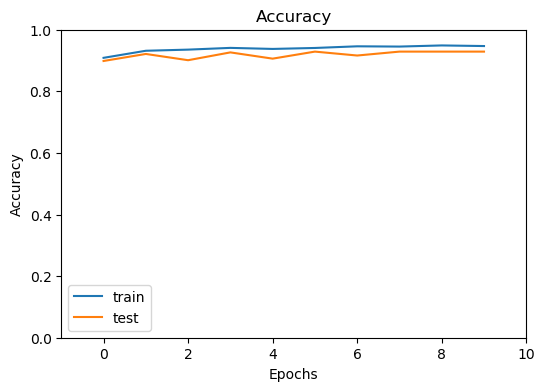

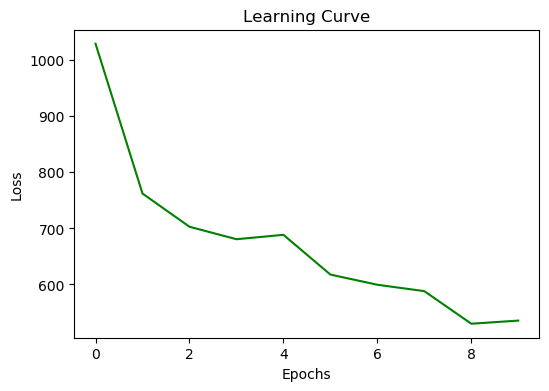

In [28]:
# plot the loss, and training & testing acc

plt.style.use("default")
plt.figure(figsize=(6,4))
plt.title("Accuracy")

plt.xlim(-1,10)
plt.ylim(0,1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(epoch_train_acc, label='train')
plt.plot(epoch_test_acc, label='test')
plt.legend(['train','test'])
plt.show()

plt.figure(figsize=(6,4))
plt.title("Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(epoch_loss, color='g')
plt.show()

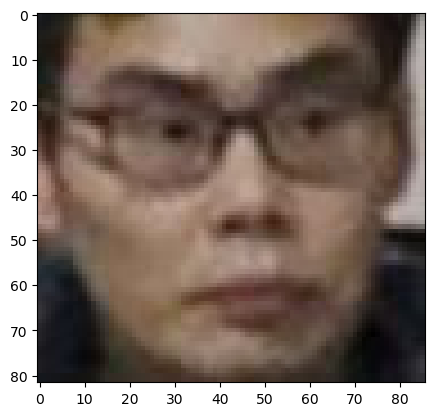

GroundTruth:    bad


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(testloader)

images, labels = dataiter.next()
classes = ('bad','good','none')

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [36]:
dataiter.next()

[tensor([[[[-0.6314, -0.6471, -0.6314,  ...,  0.1529,  0.1686,  0.1843],
           [-0.6157, -0.6314, -0.6235,  ...,  0.1529,  0.1608,  0.1608],
           [-0.6784, -0.7020, -0.6941,  ...,  0.1373,  0.1608,  0.1686],
           ...,
           [-0.4980, -0.4353, -0.3647,  ...,  0.2549,  0.2627,  0.2706],
           [-0.5922, -0.5216, -0.4275,  ...,  0.2549,  0.2627,  0.2706],
           [-0.6784, -0.6000, -0.4980,  ...,  0.2549,  0.2627,  0.2706]],
 
          [[-0.7804, -0.7961, -0.7804,  ...,  0.1529,  0.1686,  0.1843],
           [-0.7647, -0.7804, -0.7725,  ...,  0.1529,  0.1608,  0.1608],
           [-0.8275, -0.8431, -0.8275,  ...,  0.1373,  0.1608,  0.1686],
           ...,
           [-0.6471, -0.5843, -0.5137,  ...,  0.2549,  0.2549,  0.2549],
           [-0.7333, -0.6627, -0.5608,  ...,  0.2549,  0.2549,  0.2549],
           [-0.8196, -0.7412, -0.6314,  ...,  0.2549,  0.2549,  0.2549]],
 
          [[-0.8118, -0.8275, -0.8275,  ...,  0.1686,  0.1843,  0.2000],
           [-

In [ ]:
torchvision.utils.make_grid(images)

In [ ]:
# # next(iter(trainloader))[1]
# for i, data in enumerate(trainloader, 0):
#     print(data)